In [70]:
import matplotlib.pyplot as plt
from random import randint

from torch_geometric.datasets import ExplainerDataset, BA2MotifDataset, TUDataset
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer, DummyExplainer

import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx

import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, Linear, global_mean_pool, GraphConv
from torch_geometric.explain.metric import fidelity, unfaithfulness

from torch_geometric.utils import scatter

torch_geometric.seed_everything(41)

In [71]:
    
train_dataset = dataset[:int(len(dataset) * 0.8)]
test_dataset = dataset[int(len(dataset) * 0.2):]
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Data(edge_index=[2, 42], x=[19, 7], edge_attr=[42, 4], y=[1])


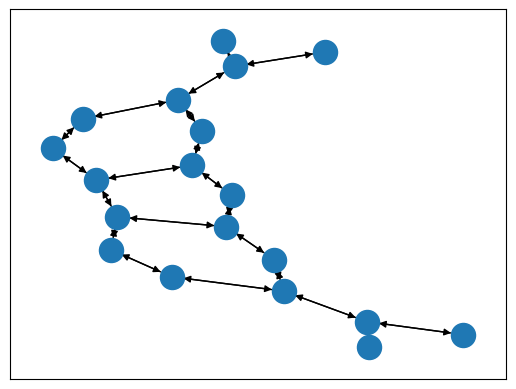

In [72]:
net = to_networkx(dataset[0])
print(dataset[0])
nx.draw_networkx(net, with_labels=False)

In [73]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [74]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [75]:
for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Train Acc: 0.6600, Test Acc: 0.6556
Epoch: 002, Train Acc: 0.6600, Test Acc: 0.6556
Epoch: 003, Train Acc: 0.6600, Test Acc: 0.6556
Epoch: 004, Train Acc: 0.6600, Test Acc: 0.6556
Epoch: 005, Train Acc: 0.6600, Test Acc: 0.6556
Epoch: 006, Train Acc: 0.6600, Test Acc: 0.6556
Epoch: 007, Train Acc: 0.6600, Test Acc: 0.6556
Epoch: 008, Train Acc: 0.6600, Test Acc: 0.6556
Epoch: 009, Train Acc: 0.7333, Test Acc: 0.7285
Epoch: 010, Train Acc: 0.7467, Test Acc: 0.7550
Epoch: 011, Train Acc: 0.7267, Test Acc: 0.7417
Epoch: 012, Train Acc: 0.7267, Test Acc: 0.7417
Epoch: 013, Train Acc: 0.7400, Test Acc: 0.7417
Epoch: 014, Train Acc: 0.7267, Test Acc: 0.7483
Epoch: 015, Train Acc: 0.7267, Test Acc: 0.7417
Epoch: 016, Train Acc: 0.7133, Test Acc: 0.7417
Epoch: 017, Train Acc: 0.7333, Test Acc: 0.7616
Epoch: 018, Train Acc: 0.7000, Test Acc: 0.7020
Epoch: 019, Train Acc: 0.7533, Test Acc: 0.7550
Epoch: 020, Train Acc: 0.7133, Test Acc: 0.6887
Epoch: 021, Train Acc: 0.7467, Test Acc:

In [53]:
graph = dataset[13]

print(model(graph.x, graph.edge_index, batch = torch.zeros(len(graph.x), dtype=int)))
graph.y

tensor([[ 0.8944, -1.0701]], grad_fn=<AddmmBackward0>)


tensor([0])

In [59]:
gnnexplainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=300),
    explanation_type='model',
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='probs',
    ),
    threshold_config=dict(
        threshold_type='topk',
        value=20
    )
)


pgexplainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=200),
    explanation_type='phenomenon',
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='probs',
    )
)


dummyexplainer = Explainer(
    model=model,
    algorithm=DummyExplainer(),
    explanation_type='phenomenon',
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='probs',
    ),
    threshold_config=dict(
        threshold_type='topk',
        value=7
    )
)

In [217]:
gnnexplainer_Unfaithfulness = []
dummyepxplainer_Unfaithfulness = []
for graph in dataset: 
    
    batch = torch.zeros(len(graph.x), dtype = int)
    if graph.y == 1:
        target = torch.tensor([0,1])
    else:
        target = torch.tensor([1,0])
        
    gnnexplanation = gnnexplainer(graph.x, graph.edge_index, target=target, batch=batch) 
    gnn_unf = unfaithfulness(gnnexplainer, gnnexplanation)
    
    dummyexplanation = dummyexplainer(graph.x, graph.edge_index, target=target, batch=batch)
    dummy_unf = unfaithfulness(dummyexplainer, dummyexplanation)
    
    gnnexplainer_Unfaithfulness.append(gnn_unf)
    dummyepxplainer_Unfaithfulness.append(dummy_unf)
    
    print(f"GNNExplainer unfaithfulness: {gnn_unf}")
    print(f"DummyExplainer unfaithfulness: {dummy_unf} \n\n")

GNNExplainer unfaithfulness: 0.0
DummyExplainer unfaithfulness: 0.0 


GNNExplainer unfaithfulness: 0.9975946107879281
DummyExplainer unfaithfulness: 0.9975946107879281 


GNNExplainer unfaithfulness: 0.0
DummyExplainer unfaithfulness: 0.0 


GNNExplainer unfaithfulness: 0.9890693742781878
DummyExplainer unfaithfulness: 0.9890693742781878 


GNNExplainer unfaithfulness: 0.9820304363965988
DummyExplainer unfaithfulness: 0.9820304363965988 


GNNExplainer unfaithfulness: 0.9978763242252171
DummyExplainer unfaithfulness: 0.9978763242252171 


GNNExplainer unfaithfulness: 0.0
DummyExplainer unfaithfulness: 0.0 


GNNExplainer unfaithfulness: 0.9822787772864103
DummyExplainer unfaithfulness: 0.9822787772864103 


GNNExplainer unfaithfulness: 1.1920928955078125e-07
DummyExplainer unfaithfulness: 1.1920928955078125e-07 




KeyboardInterrupt: 

In [81]:
def visualize_gnnexplainer_explanation(graph):      
    prediction = model(graph.x, graph.edge_index, batch = torch.zeros(len(graph.x), dtype=int))
    
    print(f"Actual label: {graph.y.item()} vs Predicted label: {prediction}")

    explanation = gnnexplainer(graph.x, graph.edge_index, batch = torch.zeros(len(dataset[10].x), dtype=int))
    graph = to_networkx(graph)
    graph = graph.copy().to_undirected()

    pos = nx.kamada_kawai_layout(graph)


    widths = [3 if x > 0 else 1 for x in explanation.edge_mask]
    edge_color = [(1,0,0) if x > 0 else (0,0,0) for x in explanation.edge_mask]
    nx.draw_networkx(graph, pos=pos)
    nx.draw_networkx_edges(graph, pos=pos, width=widths, edge_color=edge_color)

graph = dataset[0]
print(graph)
visualize_gnnexplainer_explanation(graph)

Data(edge_index=[2, 42], x=[19, 7], edge_attr=[42, 4], y=[1])
Actual label: 1 vs Predicted label: tensor([[-0.6901,  0.5603]], grad_fn=<AddmmBackward0>)


RuntimeError: all elements of input should be between 0 and 1